# Supervised Machine Learning - Data Classification Demo

This project aims to analyze and classify a real network traffic data set to detect malicious/benign traffic records. It compares the performance of various Machine Learning algorithms and tunes the best-performing model to maintain the highest accuracy and lowest False Negative metrics.

The dataset used in this demo is [CTU-IoT-Malware-Capture-34-1](https://mcfp.felk.cvut.cz/publicDatasets/IoT-23-Dataset/IndividualScenarios/CTU-IoT-Malware-Capture-34-1/bro/), it is part of [Aposemat IoT-23 dataset](https://www.stratosphereips.org/datasets-iot23) (A labeled dataset with malicious and benign IoT network traffic).

# 1. Initialization

In [1]:
#importing required libraries and modules
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import ipaddress
from sklearn.impute import KNNImputer

#set display options
pd.set_option('display.max_columns', None)

## 2. Load Dataset

### Reading dataset file into DataFrame

In [2]:
#initialize required variables to read from the data file
data_file_location = "data\\raw\\"
data_file_name = "conn.log.labeled"

#column names are included in the file in a commented line, so we need to read the corresponding line separately and remove the first description word.
data_columns = pd.read_csv(data_file_location + data_file_name, sep='\t', skiprows=6, nrows=1, header=None).iloc[0][1:]

#read the actual dataset
data_df = pd.read_csv(data_file_location + data_file_name, sep='\t', comment="#", header=None)

#set column names
data_df.columns = data_columns

### Exploring dataset summary and statistics

In [3]:
#check dataset shape
data_df.shape

(23145, 21)

In [4]:
#check dataset head
data_df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents label detailed-label
0,1.545404e+09,CrDn63WjJEmrWGjqf,192.168.1.195,41040,185.244.25.235,80,tcp,-,3.139211,0,0,S0,-,-,0,S,3,180,0,0,- Benign -
1,1.545404e+09,CY9lJW3gh1Eje4usP6,192.168.1.195,41040,185.244.25.235,80,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,- Benign -
2,1.545404e+09,CcFXLynukEDnUlvgl,192.168.1.195,41040,185.244.25.235,80,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,- Benign -
3,1.545404e+09,CDrkrSobGYxHhYfth,192.168.1.195,41040,185.244.25.235,80,tcp,http,1.477656,149,128252,SF,-,-,2896,ShADadttcfF,94,5525,96,139044,- Benign -
4,1.545404e+09,CTWZQf2oJSvq6zmPAc,192.168.1.195,41042,185.244.25.235,80,tcp,-,3.147116,0,0,S0,-,-,0,S,3,180,0,0,- Benign -


- We notice here that the last column contains several values, this is due to unmatched delimiter in the original dataset file. We will fix it later on during the data cleaning phase.
- We also notice some fields with '-', which means the field is unset according to the dataset documentation. This will be also handled when fixing missing values.

In [5]:
#check dataset summary
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23145 entries, 0 to 23144
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ts                                       23145 non-null  float64
 1   uid                                      23145 non-null  object 
 2   id.orig_h                                23145 non-null  object 
 3   id.orig_p                                23145 non-null  int64  
 4   id.resp_h                                23145 non-null  object 
 5   id.resp_p                                23145 non-null  int64  
 6   proto                                    23145 non-null  object 
 7   service                                  23145 non-null  object 
 8   duration                                 23145 non-null  object 
 9   orig_bytes                               23145 non-null  object 
 10  resp_bytes                               23145

- This summary tells there is no missing values which is not accurate (due to the unset fields with '-' values).
- Some numerical fields are misidentified as object (string) which will be fixed later as well.

# 3. Data Cleaning and Preprocessing

### Fixing combined column
The last columns in the dataset contains three separate values and needs to be unpacked into three corresponding columns. This is due to unmatched separators in the original data file.

In [6]:
#split the last combined column into three ones
tunnel_parents_column = data_df.iloc[:,-1].apply(lambda x: x.split()[0])
label_column = data_df.iloc[:,-1].apply(lambda x: x.split()[1])
detailed_label_column = data_df.iloc[:,-1].apply(lambda x: x.split()[2])

In [7]:
#drop the combined column
data_df.drop(["tunnel_parents   label   detailed-label"], axis=1, inplace=True)

In [8]:
#add new individual columns to the dataset
data_df["tunnel_parents"] = tunnel_parents_column
data_df["label"] = label_column
data_df["detailed_label"] = detailed_label_column

In [9]:
#check the dataset
data_df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed_label
0,1.545404e+09,CrDn63WjJEmrWGjqf,192.168.1.195,41040,185.244.25.235,80,tcp,-,3.139211,0,0,S0,-,-,0,S,3,180,0,0,-,Benign,-
1,1.545404e+09,CY9lJW3gh1Eje4usP6,192.168.1.195,41040,185.244.25.235,80,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,-,Benign,-
2,1.545404e+09,CcFXLynukEDnUlvgl,192.168.1.195,41040,185.244.25.235,80,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,-,Benign,-
3,1.545404e+09,CDrkrSobGYxHhYfth,192.168.1.195,41040,185.244.25.235,80,tcp,http,1.477656,149,128252,SF,-,-,2896,ShADadttcfF,94,5525,96,139044,-,Benign,-
4,1.545404e+09,CTWZQf2oJSvq6zmPAc,192.168.1.195,41042,185.244.25.235,80,tcp,-,3.147116,0,0,S0,-,-,0,S,3,180,0,0,-,Benign,-


### Drop irrelevant columns
Drop extra columns that don't contribute to the data analysis and predictions (ex. ids, columns with only unique values, columns with just one value, ...).

In [10]:
#check the number of unique values in each column
data_df.nunique().sort_values(ascending=False)

0
ts                23145
uid               23145
duration           4654
id.orig_p          4383
orig_ip_bytes       108
resp_ip_bytes        62
orig_pkts            53
id.resp_h            49
resp_bytes           44
orig_bytes           29
resp_pkts            28
history              26
id.resp_p            10
conn_state            6
service               5
detailed_label        4
missed_bytes          3
proto                 2
id.orig_h             2
label                 2
local_resp            1
local_orig            1
tunnel_parents        1
dtype: int64

In [11]:
#two columns have only unique values and three columns have only one value, so we should drop them.
data_df.drop(columns=["ts","uid","local_resp","local_orig","tunnel_parents"], inplace=True)

#the "detailed label" column provides more information about the "label" column itself, so it doesn't contribute to the data analysis.
data_df.drop(columns="detailed_label", inplace=True)

#check the dataset
data_df.head()

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,192.168.1.195,41040,185.244.25.235,80,tcp,-,3.139211,0,0,S0,0,S,3,180,0,0,Benign
1,192.168.1.195,41040,185.244.25.235,80,tcp,-,-,-,-,S0,0,S,1,60,0,0,Benign
2,192.168.1.195,41040,185.244.25.235,80,tcp,-,-,-,-,S0,0,S,1,60,0,0,Benign
3,192.168.1.195,41040,185.244.25.235,80,tcp,http,1.477656,149,128252,SF,2896,ShADadttcfF,94,5525,96,139044,Benign
4,192.168.1.195,41042,185.244.25.235,80,tcp,-,3.147116,0,0,S0,0,S,3,180,0,0,Benign


### Fix unset values and validate the data types 
According to the dataset documentation, empty and unset values are represented as "-" and "(empty)". This is why info() method did't show any missing values. Fixing these values is essential to correct the types of numeric attributes that were misinterpreted as string.

In [12]:
#replace all occurrences of empty/unset cells with null values.
data_df.replace({'-':np.nan, "(empty)":np.nan}, inplace=True)

In [13]:
#fix the data type for the misinterpreted columns.
dtype_convert_dict = {
    "duration": float,
    "orig_bytes": float,
    "resp_bytes": float
}
data_df = data_df.astype(dtype_convert_dict)

In [14]:
#check the dataset summary.
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23145 entries, 0 to 23144
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id.orig_h      23145 non-null  object 
 1   id.orig_p      23145 non-null  int64  
 2   id.resp_h      23145 non-null  object 
 3   id.resp_p      23145 non-null  int64  
 4   proto          23145 non-null  object 
 5   service        1847 non-null   object 
 6   duration       5321 non-null   float64
 7   orig_bytes     5321 non-null   float64
 8   resp_bytes     5321 non-null   float64
 9   conn_state     23145 non-null  object 
 10  missed_bytes   23145 non-null  int64  
 11  history        23145 non-null  object 
 12  orig_pkts      23145 non-null  int64  
 13  orig_ip_bytes  23145 non-null  int64  
 14  resp_pkts      23145 non-null  int64  
 15  resp_ip_bytes  23145 non-null  int64  
 16  label          23145 non-null  object 
dtypes: float64(3), int64(7), object(7)
memory usage: 3

### Encode IP addresses
Some columns contain IP addresses which need to be encoded into a corresponding numeric format

In [15]:
#function to encode an ip address using the IPv4/IPv6 manipulation library
def encode_ipv4(ip):
    return int(ipaddress.IPv4Address(ip))

In [16]:
#encoding ip features into numerical values
data_df["id.orig_h"] = data_df["id.orig_h"].apply(encode_ipv4)
data_df["id.resp_h"] = data_df["id.resp_h"].apply(encode_ipv4)

In [17]:
#check encoded ip addresses
data_df[["id.orig_h","id.resp_h"]].head()

,id.orig_h,id.resp_h
0,3232235971,3119782379
1,3232235971,3119782379
2,3232235971,3119782379
3,3232235971,3119782379
4,3232235971,3119782379


### Handle missing values

In [18]:
#check the number of null values in each column
data_df.isnull().sum().sort_values(ascending=False)

0
service          21298
resp_bytes       17824
duration         17824
orig_bytes       17824
missed_bytes         0
resp_ip_bytes        0
resp_pkts            0
orig_ip_bytes        0
orig_pkts            0
history              0
id.orig_h            0
conn_state           0
id.orig_p            0
proto                0
id.resp_p            0
id.resp_h            0
label                0
dtype: int64

<Axes: xlabel='0'>

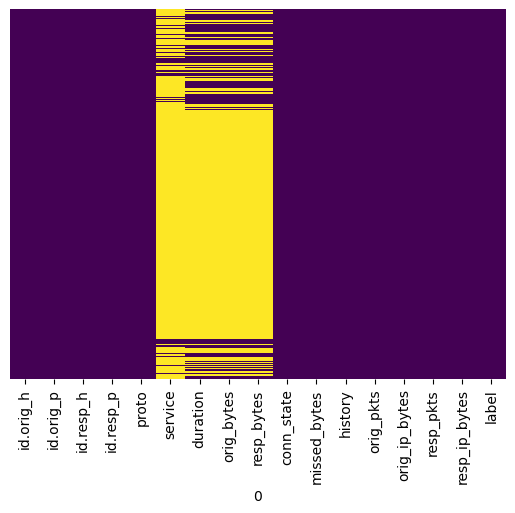

In [19]:
#check null values using heatmap
sns.heatmap(data=data_df.isnull(), yticklabels=False, cbar=False, cmap="viridis")

- There are only 4 columns with a lot of missing values, one categorical ("service) and three numerical (["duration","orig_bytes","resp_bytes"]).
- One possible approach is to entirely discard these columns from the dataset. Instead, we will try to impute their values to preserve any hidden information and check it we could obtain better prediction performance.

#### Impute missing values: categorical features

<Axes: xlabel='label', ylabel='count'>

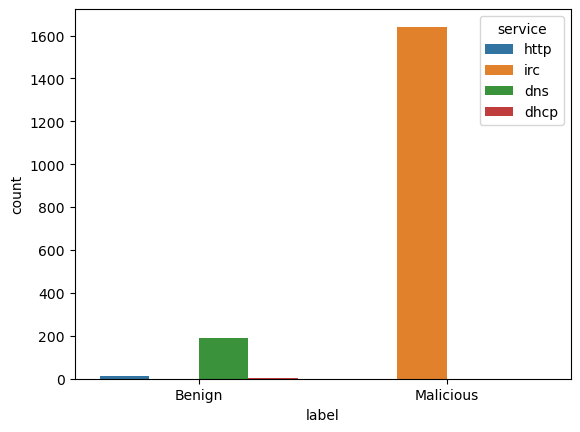

In [20]:
#check the relationship between "service" and target attribute
sns.countplot(data=data_df, x="label", hue="service")

- Due to this visualization, almost all *Malicious* observations belong to a specific service type ("irc"), while the other 3 types represent *Benign* samples.
- Accordingly, although "service" has high number of missing values, it has a strong correlation with the target attribute.
- The decision here is to keep "service" attribute while trying to impute missing values using another classifier. 

In [21]:
#select specific columns to be used for the classification, here we initially select the numerical attributes with no missing values.
srv_training_columns = ["id.orig_h","id.orig_p","id.resp_h","id.resp_p","missed_bytes","orig_pkts","orig_ip_bytes","resp_pkts","resp_ip_bytes"] 

#split the rows into two datasets containing rows with/without "service".
data_df_with_service = data_df[data_df["service"].notna()]
data_df_no_service = data_df[data_df["service"].isna()]

#split the service dataset into dependent and independent features
srv_X = data_df_with_service[srv_training_columns]
srv_y = data_df_with_service["service"].values

#split into train/test subsets
srv_X_train, srv_X_test, srv_y_train, srv_y_test = train_test_split(srv_X, srv_y, test_size=0.2, random_state=0)

#create KNN estimator and fit it
srv_knn = KNeighborsClassifier(n_neighbors=3)
srv_knn.fit(srv_X_train, srv_y_train)

#predict missing values
srv_y_pred = srv_knn.predict(srv_X_test)

#check accuracy of predictions
srv_accuracy_test = accuracy_score(srv_y_test, srv_y_pred)
print(f"Prediction accuracy for 'service' is: {srv_accuracy_test}")
print("Classification report:")
print(classification_report(srv_y_test, srv_y_pred))

Prediction accuracy for 'service' is: 1.0
Classification report:
              precision    recall  f1-score   support

         dns       1.00      1.00      1.00        41
        http       1.00      1.00      1.00         5
         irc       1.00      1.00      1.00       324

    accuracy                           1.00       370
   macro avg       1.00      1.00      1.00       370
weighted avg       1.00      1.00      1.00       370



The classification model achieved an accuracy of 1, which means all samples in the test subset were correctly predicted. Now we can use this model to predict missing "service" fields.

In [22]:
#predict "service" for missing values
srv_predictions = srv_knn.predict(data_df_no_service[srv_training_columns])

#update the original data set with predicted "service" values
data_df.loc[data_df["service"].isna(), "service"] = srv_predictions

#### Impute missing values: numerical features

In [23]:
#to preserve hidden correlations with other features in the dataset, we will use a KNN imputer to estimate the missing values based on relationships wit other numerical features.
numerical_features = data_df.select_dtypes(include="number").columns
knn_imputer = KNNImputer()
data_df_after_imputing = knn_imputer.fit_transform(data_df[numerical_features])

In [24]:
#update original data set to fill with imputed values
data_df[numerical_features] = data_df_after_imputing

In [26]:
#confirm all missing values were successfully imputed
data_df.isnull().sum().sort_values(ascending=False)

0
id.orig_h        0
conn_state       0
resp_ip_bytes    0
resp_pkts        0
orig_ip_bytes    0
orig_pkts        0
history          0
missed_bytes     0
resp_bytes       0
id.orig_p        0
orig_bytes       0
duration         0
service          0
proto            0
id.resp_p        0
id.resp_h        0
label            0
dtype: int64